In [1]:
import torch

ModuleNotFoundError: No module named 'torch3e3e'

In [46]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device231

In [47]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [48]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


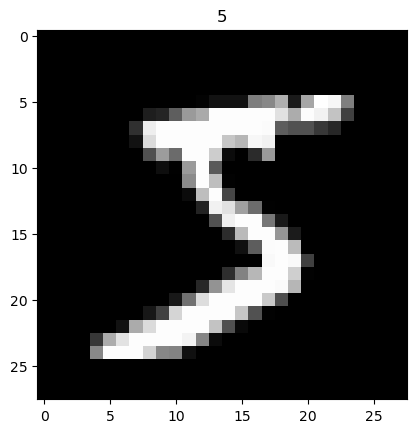

In [49]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [50]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3e28265090>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f3e211c08d0>}

In [51]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [52]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [53]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [54]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [55]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [56]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)

            writer.add_scalar("Loss/train", loss, epoch)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
                pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)
# writer.flush()
# writer.close()

Epoch [1/10], Step [100/600], Loss: 0.1755
Epoch [1/10], Step [200/600], Loss: 0.1375
Epoch [1/10], Step [300/600], Loss: 0.0748
Epoch [1/10], Step [400/600], Loss: 0.0246
Epoch [1/10], Step [500/600], Loss: 0.0442
Epoch [1/10], Step [600/600], Loss: 0.0903
Epoch [2/10], Step [100/600], Loss: 0.0313
Epoch [2/10], Step [200/600], Loss: 0.0354
Epoch [2/10], Step [300/600], Loss: 0.1767
Epoch [2/10], Step [400/600], Loss: 0.0595
Epoch [2/10], Step [500/600], Loss: 0.0738
Epoch [2/10], Step [600/600], Loss: 0.0853
Epoch [3/10], Step [100/600], Loss: 0.0787
Epoch [3/10], Step [200/600], Loss: 0.1013
Epoch [3/10], Step [300/600], Loss: 0.0557
Epoch [3/10], Step [400/600], Loss: 0.0098
Epoch [3/10], Step [500/600], Loss: 0.0418
Epoch [3/10], Step [600/600], Loss: 0.0429
Epoch [4/10], Step [100/600], Loss: 0.0216
Epoch [4/10], Step [200/600], Loss: 0.0322
Epoch [4/10], Step [300/600], Loss: 0.0068
Epoch [4/10], Step [400/600], Loss: 0.0668
Epoch [4/10], Step [500/600], Loss: 0.0557
Epoch [4/10

In [64]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_index, (images, labels) in enumerate(loaders['test']):
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            batch_correct = (pred_y == labels).sum().item()
            batch_total = labels.size(0)
            batch_acc = batch_correct / float(batch_total)
            writer.add_scalar('Accuracy/Batch', batch_acc, batch_index)

            correct += batch_correct
            total += batch_total
            # writer.add_scalar("Accuracy/validation", loss_func(pred_y, labels))
            # pass
        print('Validation Accuracy of the model on the 10000 test images:', correct/float(total))
    
test()

Validation Accuracy of the model on the 10000 test images: 0.982


In [65]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7715), started 0:28:15 ago. (Use '!kill 7715' to kill it.)

In [66]:
!pip install -U albumentations


  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/9b/f6/c486cedb4f75147232f32ec4c97026714cfef7c7e247a1f0427bc5489f66/albumentations-1.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.1.1 from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 64.5 MB/s eta 0:00:000m eta 0:00:01:01:01m


In [76]:
import albumentations as A

In [101]:
im1 = train_data.data[0]
print(train_data.train_labels[0])
im1.shape

tensor(5)


/home/rz4983/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([28, 28])

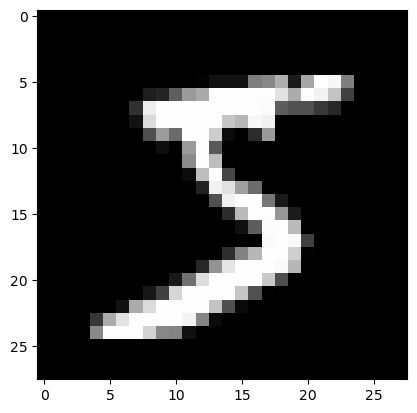

In [78]:
plt.imshow(im1, cmap='gray')

In [88]:
MyTransform = A.Compose([
    A.Rotate(limit=30),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
])

In [89]:
im1_t = MyTransform(image=im1.numpy())['image']

In [90]:
im1_t.shape

(28, 28)

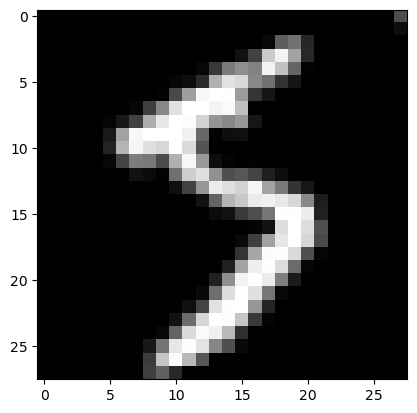

In [100]:
plt.imshow(im1_t, cmap='gray')

In [115]:
def test_with_new_image(image):
    test_im1 = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        output, last_layer = cnn(test_im1)
        prediction = torch.max(output, 1)[1].data.squeeze()
        print(f"Predicted Digit: {prediction.item()}")

In [116]:
test_with_new_image(im1_t)

Predicted Digit: 3


tensor(0)


/home/rz4983/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


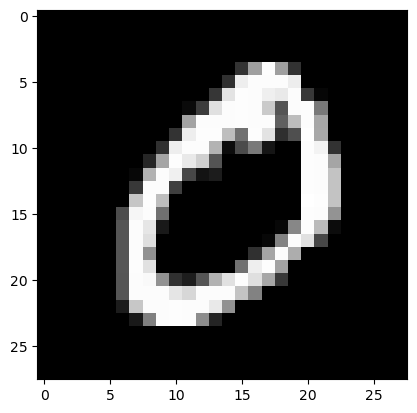

In [117]:
im2 = train_data.data[1]
print(train_data.train_labels[1])
plt.imshow(im2, cmap='gray')

In [123]:
MyTransform = A.Compose([
    A.RandomResizedCrop(height=28, width=28),
    A.Rotate(limit=30),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
])

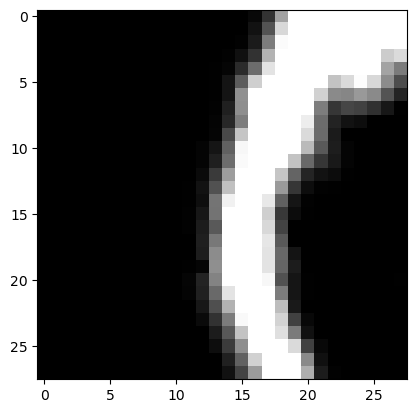

In [126]:
im2_t = MyTransform(image=im2.numpy())['image']
plt.imshow(im2_t, cmap='gray')

In [127]:
test_with_new_image(im2_t)

Predicted Digit: 7


tensor(4)


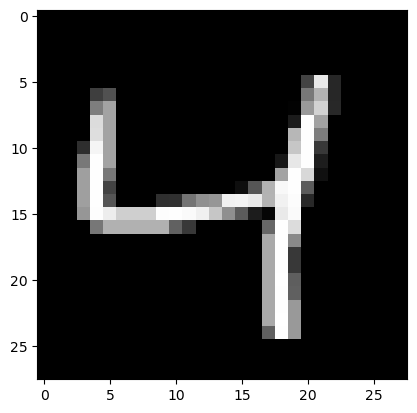

In [130]:
im3 = train_data.data[2]
print(train_data.train_labels[2])
plt.imshow(im3, cmap='gray')

Predicted Digit: 5


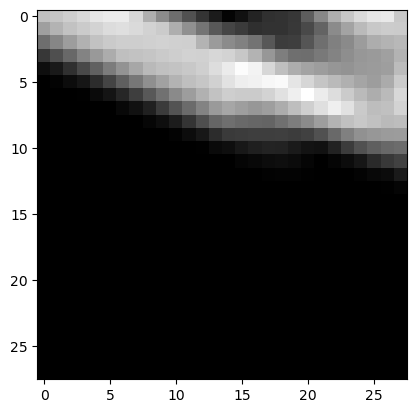

In [131]:
im3_t = MyTransform(image=im3.numpy())['image']
plt.imshow(im3_t, cmap='gray')
test_with_new_image(im3_t)

In [134]:
torch.save(cnn.state_dict(), 'weights.pth')